# Usando o Scikit-Learn para lidar com problemas de classificação

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scikitplot.estimators import plot_learning_curve
from scikitplot.metrics import plot_confusion_matrix

In [51]:
warnings.filterwarnings("ignore")

Como exemplo, utilizaremos conjuntos de dados disponibilizados pela própria biblioteca. Vamos começar carregando o dataset iris.

In [2]:
iris = datasets.load_iris()

Para facilitar o processo de visualização, podemos incluir as variáveis (dependente e independentes) um DataFrame.

In [3]:
data = np.append(iris.data, iris.target.reshape(150,1), 1)
colnames = ["_".join(name.split()[:2]) for name in iris.feature_names] + ['target']

In [4]:
df = pd.DataFrame(data, columns= colnames)

É importante conferir se tudo saiu como esperávamos.

In [5]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Qual o dtype de cada coluna? Há dados faltantes?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


Note que a coluna target contém, na verdade, variáveis categóricas representando cada uma das espécies de iris. Dessa forma, trata-se de uma variável categórica.

In [7]:
df['target'] = df['target'].astype('category')

Podemos ver como os códigos estão associados aos nomes das espécies:

In [8]:
for name,code in zip(iris.target_names, np.unique(iris.target)):
    print(f"{name} = {code}")

setosa = 0
versicolor = 1
virginica = 2


Quantos exemplares de cada espécie?

In [9]:
df['target'].value_counts()

0.0    50
1.0    50
2.0    50
Name: target, dtype: int64

Logo, temos um dataset balanceado, não sendo necessário, portanto, a aplicação de técnicas de *oversampling*.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56344403d0>,
      dtype=object)

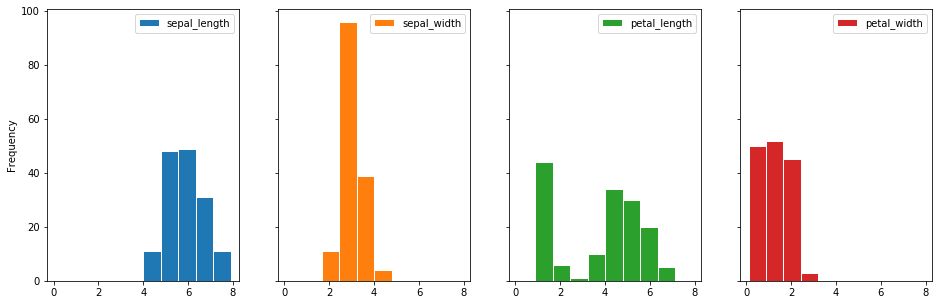

In [10]:
df.iloc[:, 0:4].plot(kind = 'hist', subplots = True,
                     sharey = True, layout = (1,df.shape[1]),
                    figsize = (20, 5), edgecolor = 'white')

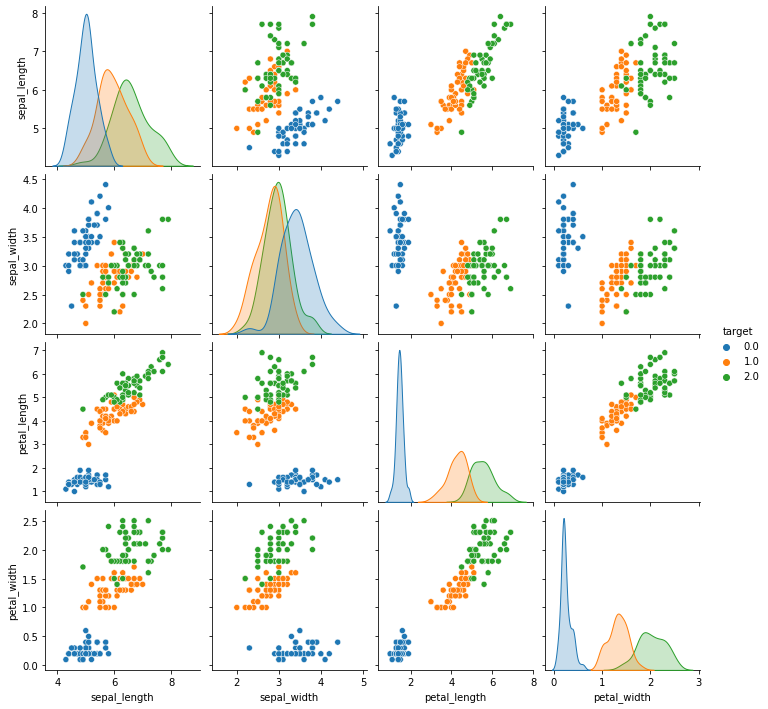

In [11]:
sns.pairplot(df, hue = 'target')

Separando os dados em conjuntos de treino e teste. Note que estamos incluindo uma coluna de 'uns' à matriz de variáveis independentes para criar uma *model matrix*.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(add_constant(iris.data), iris.target, test_size=0.25, random_state=1)

Vamos usar cross-validation para ajustar os hiperparâmetros dos modelos de machine learning. Vamos testar 3 algoritmos: `SVC`, `LogisticRegression` e `KNeighborsClassifier`. Além disso, vamos *centralizar* os dados usando `StandardScaler`.

In [13]:
estimators_svc = [('scaler', StandardScaler()), ('clf', SVC())]
estimators_lrg = [('scaler', StandardScaler()), ('clf', LogisticRegression(fit_intercept=True))]
estimators_knn = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]

In [14]:
svc_pipe = Pipeline(estimators_svc)
lrg_pipe = Pipeline(estimators_lrg)
knn_pipe = Pipeline(estimators_knn)

Definindo os parâmetros que serão testados para cada modelo

In [15]:
svc_par = {'clf__C': [0.1, 0.5, 1, 5, 10]}
lrg_par = {'clf__penalty': ['none', 'l1', 'l2'], 'clf__C': [0.1, 0.5, 1, 5, 10], 'clf__class_weight': ['balanced', 'None'], 'clf__solver': ['newton-cg', 'lbfgs']}
knn_par = {'clf__n_neighbors': [2, 3, 4, 5], 'clf__weights': ['uniform', 'distance']}

A busca exaustiva pelo espaço de parâmetros definidos acima será feita por meio de `GridSearchCV`.

In [18]:
svc_grid = GridSearchCV(svc_pipe, param_grid=svc_par, scoring = 'f1_macro')
lrg_grid = GridSearchCV(lrg_pipe, param_grid=lrg_par, scoring = 'f1_macro')
knn_grid = GridSearchCV(knn_pipe, param_grid=knn_par, scoring = 'f1_macro')

## SVC

Treinando o modelo

In [19]:
svc_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': [0.1, 0.5, 1, 5, 10]}, scoring='f1_macro')

Checando os "melhores" parâmetros

In [20]:
svc_grid.best_params_

{'clf__C': 5}

In [23]:
print(classification_report(y_test, svc_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



Construindo uma matriz de confusão

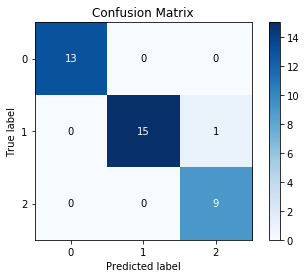

In [24]:
plot_confusion_matrix(y_test, svc_grid.predict(X_test))

Plotando a curva de aprendizado

In [25]:
svc_pipe.steps = [('scaler', StandardScaler()), ('clf', SVC(C = 5))]

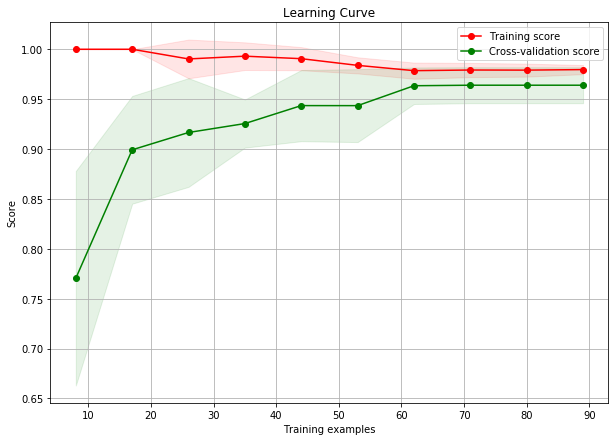

In [27]:
plot_learning_curve(svc_pipe, X_train, y_train, cv = 5, train_sizes=np.linspace(.1, 1.0, 10), scoring = 'f1_macro', figsize = (10,7))

## LogisticRegression

In [53]:
lrg_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(C=5,
                                                           class_weight='balanced',
                                                           solver='newton-cg'))]),
             param_grid={'clf__C': [0.1, 0.5, 1, 5, 10],
                         'clf__class_weight': ['balanced', 'None'],
                         'clf__penalty': ['none', 'l1', 'l2'],
                         'clf__solver': ['newton-cg', 'lbfgs']},
             scoring='f1_macro')

In [30]:
lrg_grid.best_params_

{'clf__C': 5,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'clf__solver': 'newton-cg'}

In [31]:
print(classification_report(y_test, lrg_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



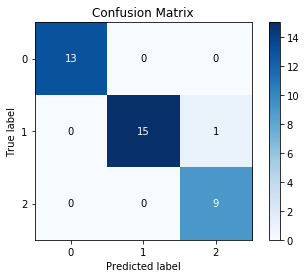

In [32]:
plot_confusion_matrix(y_test, lrg_grid.predict(X_test))

In [33]:
lrg_pipe.steps = [('scaler', StandardScaler()), ('clf', LogisticRegression(C = 5, class_weight = 'balanced', penalty = 'l2', solver = 'newton-cg'))]

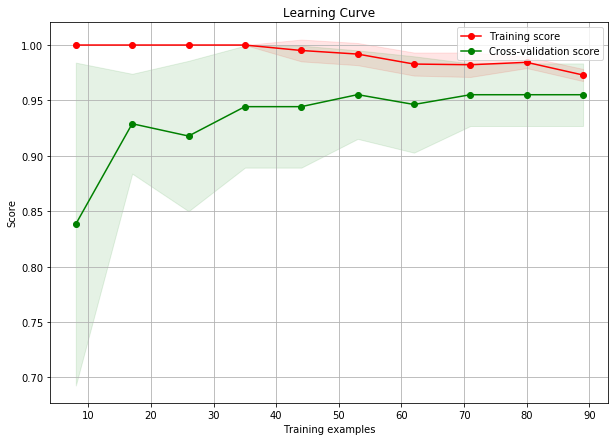

In [34]:
plot_learning_curve(lrg_pipe, X_train, y_train, cv = 5, train_sizes=np.linspace(.1, 1.0, 10), scoring = 'f1_macro', figsize = (10,7))

## KNeighborsClassifier

In [35]:
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [2, 3, 4, 5],
                         'clf__weights': ['uniform', 'distance']},
             scoring='f1_macro')

In [36]:
knn_grid.best_params_

{'clf__n_neighbors': 4, 'clf__weights': 'uniform'}

In [37]:
print(classification_report(y_test, knn_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00         9

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



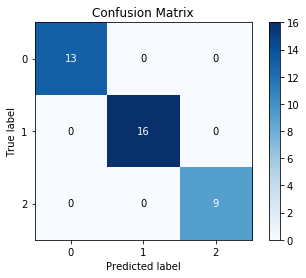

In [38]:
plot_confusion_matrix(y_test, knn_grid.predict(X_test))

In [39]:
knn_pipe.steps = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors = 4, weights = 'uniform'))]

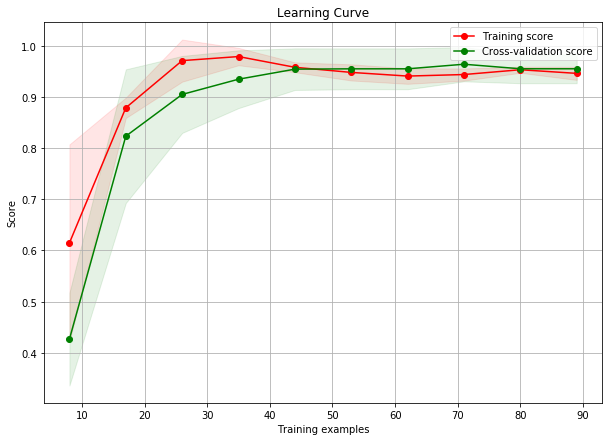

In [40]:
plot_learning_curve(knn_pipe, X_train, y_train, cv = 5, train_sizes=np.linspace(.1, 1.0, 10), scoring = 'f1_macro', figsize = (10,7))

# Classes desbalanceadas
O que aconteceria se tivéssemos classes desbalanceadas?

In [42]:
n_iris = np.concatenate([iris.data, iris.target.reshape(150,1)], axis = 1); n_iris

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [4.6, 3.4, 1.4, 0.3, 0. ],
       [5. , 3.4, 1.5, 0.2, 0. ],
       [4.4, 2.9, 1.4, 0.2, 0. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.4, 1.6, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.7, 4.4, 1.5, 0.4, 0. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [5.1, 3.5, 1.4, 0.3, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.1, 3.8, 1.5, 0.3, 0. ],
       [5.4, 3.4, 1.7, 0.2, 0. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [4.6, 3.6, 1. , 0.2, 0. ],
       [5.1, 3.3, 1.7, 0.5, 0. ],
       [4.8, 3.4, 1.9, 0.2, 0. ],
       [5. , 3. , 1.6, 0.2, 0. ],
       [5. , 3.4, 1.6, 0.4, 0. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.2, 3.4, 1.4, 0.2, 0. ],
       [4.7, 3

criando um dataset com classes desbalanceadas

In [46]:
setosa = n_iris[:,4] == 0
versicolor = n_iris[:, 4] == 1
virginica = n_iris[:, 4] == 2
n_iris = np.vstack([n_iris[setosa], n_iris[versicolor][:7, :],
                    n_iris[virginica][:7, :]])

In [47]:
n_iris

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [4.6, 3.4, 1.4, 0.3, 0. ],
       [5. , 3.4, 1.5, 0.2, 0. ],
       [4.4, 2.9, 1.4, 0.2, 0. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.4, 1.6, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.7, 4.4, 1.5, 0.4, 0. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [5.1, 3.5, 1.4, 0.3, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.1, 3.8, 1.5, 0.3, 0. ],
       [5.4, 3.4, 1.7, 0.2, 0. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [4.6, 3.6, 1. , 0.2, 0. ],
       [5.1, 3.3, 1.7, 0.5, 0. ],
       [4.8, 3.4, 1.9, 0.2, 0. ],
       [5. , 3. , 1.6, 0.2, 0. ],
       [5. , 3.4, 1.6, 0.4, 0. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.2, 3.4, 1.4, 0.2, 0. ],
       [4.7, 3

In [48]:
nx = n_iris[:, :4]
ny = n_iris[:, -1]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(nx, ny, test_size=0.25, random_state=1)

In [52]:
estimators_svc = [('scaler', StandardScaler()), ('clf', SVC())]
svc_pipe = Pipeline(estimators_svc)
svc_par = {'clf__C': [0.1, 0.5, 1, 5, 10]}
svc_grid = GridSearchCV(svc_pipe, param_grid=svc_par, scoring = 'f1_macro')

In [54]:
svc_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': [0.1, 0.5, 1, 5, 10]}, scoring='f1_macro')

In [55]:
svc_grid.best_params_

{'clf__C': 5}

In [56]:
print(classification_report(y_test, svc_grid.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        11
         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         2

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [57]:
svc_pipe.steps = [('scaler', StandardScaler()), ('clf', SVC(C = 5))]

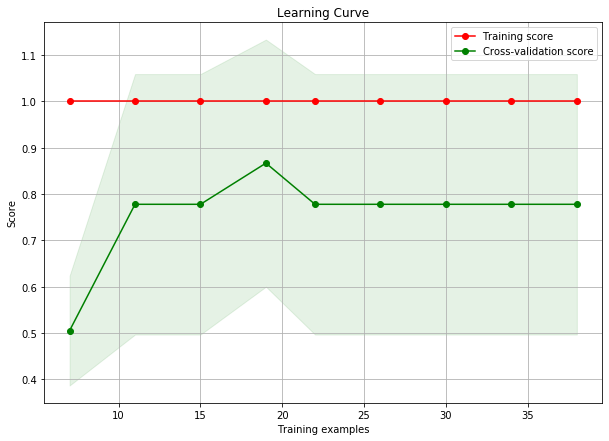

In [58]:
plot_learning_curve(svc_pipe, X_train, y_train, cv = 5, train_sizes=np.linspace(.1, 1.0, 10), scoring = 'f1_macro', figsize = (10,7))

Vemos que o modelo não se comporta muito bem com os dados de validação, gerando uma curva de aprendizado que indica sobreajuste (sugerindo que o modelo possa não ser muito útil para previsões). Uma forma de lidar com conjunto de dados com classes desbalanceadas é empregar métodos de reamostragem. Aqui utilizaremos o método de *Synthetic Minority Oversampling Technique* (SMOTE), disponibilizado no módulo Imbalanced-learn.

In [60]:
from imblearn.over_sampling import SMOTE

In [61]:
X_resampled, y_resampled = SMOTE().fit_resample(nx, ny)

In [62]:
y_resampled

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

Podemos repetir todo o processo para gerar a curva de aprendizado.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=1)

In [64]:
estimators_svc = [('scaler', StandardScaler()), ('clf', SVC())]
svc_pipe = Pipeline(estimators_svc)
svc_par = {'clf__C': [0.1, 0.5, 1, 5, 10]}
svc_grid = GridSearchCV(svc_pipe, param_grid=svc_par, scoring = 'f1_macro')

In [65]:
svc_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': [0.1, 0.5, 1, 5, 10]}, scoring='f1_macro')

In [66]:
svc_grid.best_params_

{'clf__C': 1}

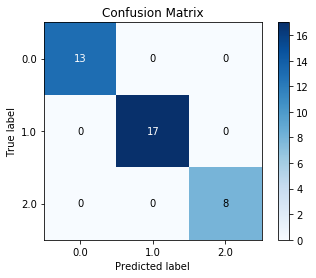

In [69]:
plot_confusion_matrix(y_test, svc_grid.predict(X_test))

In [67]:
svc_pipe.steps = [('scaler', StandardScaler()), ('clf', SVC(C = 1))]

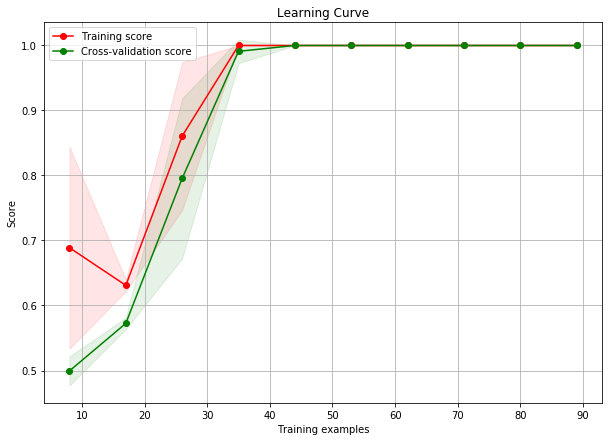

In [68]:
plot_learning_curve(svc_pipe, X_train, y_train, cv = 5, train_sizes=np.linspace(.1, 1.0, 10), scoring = 'f1_macro', figsize = (10,7))